# Deep Learning: use case

Programme de ce TP:
- Implémenter de A à Z l'entraînement d'un réseau de segmentation de tissus:
    - Gérer les flux de données
    - Comprendre le principe d'augmentation de données
    - Construire un modèle d'apprentissage profond
    - Entraîner ce modèle et évaluer ses performances
    
Tout au long de ce TP, vous pouvez consulter en parallèle, selon votre niveau, les références suivantes:

- Pour les amateurs de Wikipédia (presque sans maths): https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif
- Grands concepts en deep learning (avec un peu de maths): https://stanford.edu/~shervine/l/fr/teaching/cs-230/pense-bete-reseaux-neurones-convolutionnels
- Introduction au deep learning (avec plus de maths): http://chercheurs.lille.inria.fr/pgermain/neurones2018/06-slides.pdf
- TP du DU IA en santé réalisé en 2021: https://nbviewer.jupyter.org/github/afiliot/TPDUIA/blob/main/TPDUIA/convolution_tp3.ipynb

# Prérequis pour ouvrir le notebook (liste diffusée par mail)

- 0) Créer un compte Google pour avoir accès à Google Drive.
- 1) Ouvrir ce lien de partage : https://drive.google.com/drive/folders/1j-XK2umdsMwAPsOgEgqt4rR56q6oBGSf?usp=sharing
- 2) Dans l'en-tête "Partagés avec moi", aller dans "data", et cliquer sur "ajouter à mon drive".
- 3) Pour ouvrir les TP, aller d'abord dans https://colab.research.google.com/
- 4) Sur la page de chargement (figure ci-dessous): cliquer sur "GitHub", puis rentrer le lien https://github.com/afiliot/TPDUIA ; vous pouvez refuser les demandes d'autorisation. Puis, dans le menu déroulant des fichiers, sélectionnez `TPDUIA/2022/tumor_annotations.ipynb`

# Prérequis après ouverture du notebook

- 5) Cliquer dans le menu sur `Affichage` puis `Dérouler les rubriques`.
- 6) Réaliser un point de montage avec le contenu de son drive pour accéder aux données du TP (cliquez sur la cellule ci-dessous).
- 7) Une fois le notebook ouvert, cliquer sur `Modifier` puis `Paramètres du notebook` puis `accélérateur matériel`, et finalement `GPU` pour disposer d'une carte graphique virtualisée.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

# Installer tensorflow et tensorflow-datasets

In [ ]:
!pip install tensorflow
!pip install tensorflow-datasets
!pip install -U tensorboard-plugin-profile

# Ajout du code `scripts.py` dans Colab

In [ ]:
import sys
sys.path.insert(0, '/content/gdrive/My Drive/TPDUIA/')

# Import des librairies nécessaires

In [2]:
# librairies utilitaires
from typing import List, Tuple
import os

# numpy pour les matrices
import numpy as np

# pandas pour les dataframe
import pandas as pd

# tensorflow pour le deep learning
import tensorflow as tf
print(f'Loaded Tensorflow version {tf.__version__}')

# tensorflow_datasets pour les données
import tensorflow_datasets as tfds

# librairies pour la visualisation
import matplotlib.pyplot as plt

Loaded Tensorflow version 2.4.0


# Le cas d'application

On s'intéresse au jeu de données : `colorectal_histology`, issu de l'article suivant: 

**Kather, J., Weis, CA., Bianconi, F. et al. Multi-class texture analysis in colorectal cancer histology. Sci Rep 6, 27988 (2016). https://doi.org/10.1038/srep27988**

Ce data set consiste en la classification en 8 classes d'images histologiques de taille 150x150x3 de tissus prélevés dans le cadre de l'étude du cancer colorectal.
L'image ci-dessous est tirée de l'article de Kather et al., et reprend, pour chaque ligne, l'un des **8 types de tissus à classifier**. L'apprentissage est rendu possible grâce à l'annotations de dizaines de lames par des experts anatomopathologistes.

    All images are RGB, 0.495 µm per pixel, digitized with an Aperio ScanScope (Aperio/Leica biosystems), magnification 20x. Histological samples are fully anonymized images of formalin-fixed paraffin-embedded human colorectal adenocarcinomas (primary tumors) from our pathology archive (Institute of Pathology, University Medical Center Mannheim, Heidelberg University, Mannheim, Germany).

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fsrep27988/MediaObjects/41598_2016_Article_BFsrep27988_Fig1_HTML.jpg?as=webp" width="800">

Légende: _**Representative images from our dataset.** Here, the first 10 images of every tissue class in our dataset are shown. They represent the wide variation of illumination, stain intensity and tissue textures present in routine histopathological images. Images were extracted from 10 independent samples of colorectal cancer (CRC) primary tumours. **(a) tumour epithelium, (b) simple stroma, (c) complex stroma (stroma that contains single tumour cells and/or single immune cells), (d) immune cell conglomerates, (e) debris and mucus, (f) mucosal glands, (g) adipose tissue, (h) background.**_

# Prise en main des données

### Chargement des données avec `tensorflow-datasets`.

On charge les données grâce à la librairies tensorflow-datasets et on constitue 3 jeux de données: l'entraînement (`train`, 80%), le jeu d'optimisation des hyperparamètres (`val`, 10%) et la validation externe (ou `test`, 10%). Le schéma ci-dessous présente deux grandes pratiques pour séparer les données: la validation croisée (en haut) et une approche plus standard train / val / test (en bas). La validation croisée est, sous couvert d'un jeu de données suffisamment grand, la méthode la plus robuste pour sélectionner les hyperparamètres (taux d'apprentissage, nombre de couches, stratégie d'entraînement, régularisation, etc.) mais également pour évaluer un modèle.

Ici, nous allons utiliser l'approche standard pour des raisons de temps de calcul (une validation croisée à 5 plis implique de réaliser 5 entraînements différents!).

![img1](https://cdn-images-1.medium.com/max/1600/1*4G__SV580CxFj78o9yUXuQ.png "Source: https://cdn-images-1.medium.com/max/1600/1*4G__SV580CxFj78o9yUXuQ.png")

Source (très instructive, anglais): https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

In [3]:
# arguments communs
args = {
    'shuffle_files': False, # on permute aléatoirement les images.
    'batch_size': 1, # taille de batch : 1 (pour commencer)
    'as_supervised': False,
    'data_dir': '/data/freganet/TPDU/', #'/content/gdrive/MyDrive/TPDUIA/',
    'with_info': True,
    'download': False
}
# 3 jeux de données : train, validation et test
ds_train, info = tfds.load(
    'colorectal_histology',
    split='train[:80%]', 
    **args
)
ds_val, info = tfds.load(
    'colorectal_histology',
    split='train[80%:90%]',
    **args
)
ds_test, info = tfds.load(
    'colorectal_histology',
    split='train[90%:]',
    **args
)
# on affiche les informations associées à l'intégralité du data set
print(info)

tfds.core.DatasetInfo(
    name='colorectal_histology',
    full_name='colorectal_histology/2.0.0',
    description="""
    Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.
    """,
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    data_path='/data/freganet/TPDU/colorectal_histology/2.0.0',
    download_size=246.14 MiB,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(150, 150, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'train': <SplitInfo num_examples=5000, num_shards=2>,
    },
    citation="""@article{kather2016multi,
      title={Multi-class texture analysis in colorectal cancer histology},
      author={Kather, Jakob Nikolas and Weis, Cleo-Aron and Bianconi, Francesco and Melchers, Susann

### Type de données

In [ ]:
print(info.features)

### Nom des classes

In [4]:
classes = [
    'tumour epithelium', 'simple stroma',
    'complex stroma', 'immune cell conglomerate',
    'debris and mucus', 'mucosal glands',
    'adipose tissue', 'background'
]
classes_dict = dict(enumerate(classes))
print(classes_dict)

{0: 'tumour epithelium', 1: 'simple stroma', 2: 'complex stroma', 3: 'immune cell conglomerate', 4: 'debris and mucus', 5: 'mucosal glands', 6: 'adipose tissue', 7: 'background'}


### Stockage des images à des fins de visualisation

In [5]:
from scripts import store_data

filenames_train, images_train, labels_train = store_data(ds_train)
filenames_val, images_val, labels_val = store_data(ds_val)
filenames_test, images_test, labels_test = store_data(ds_test)

print(f"\nNombre d'images stockées d'entraînement : {len(images_train)}")
print(f"Nombre d'images stockées en validation : {len(images_val)}")
print(f"Nombre d'images stockées en test : {len(images_test)}")

100%|██████████| 500/500 [00:00<00:00, 2875.32it/s]



Nombre d'images stockées d'entraînement : 4000
Nombre d'images stockées en validation : 500
Nombre d'images stockées en test : 500


### Distribution des classes sur les 3 échantillons

In [ ]:
from scripts import get_train_val_test_labels_distributions

get_train_val_test_labels_distributions(
    [labels_train, labels_val, labels_test]
)

### Affichage des images par classes de tissus à prédire

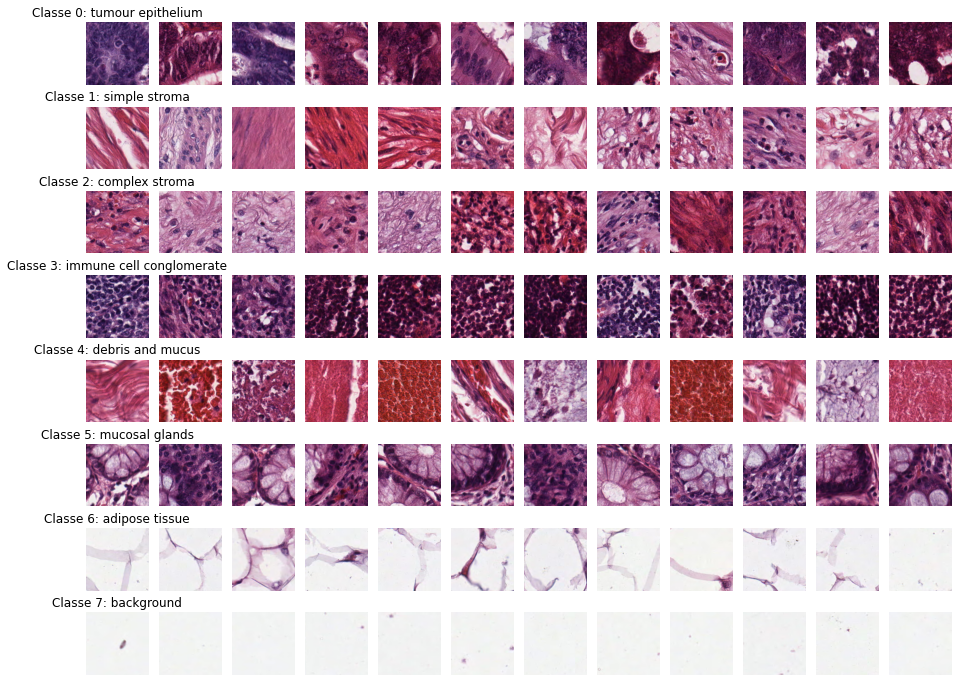

In [632]:
from scripts import plot_images
    
plot_images(images_train, labels_train)

# Augmentation des images

Lors de l'apprentissage d'un réseau de neurones profond, on procède généralemet à ce que l'on appelle `data augmentation`.
L'augmentation de données a pour but, à chaque itération d'entraînement, de montrer une version différente des images qui ont déjà été utilisées à la précédente itération.
Ainsi, le réseau de neurones ne voit que des variations des images d'origine. On essaie par ce biais de favoriser la généralisation de l'algorithme et éviter le phénomène de sur-apprentissage. Cette étape est systématiquement implémentée dans la quasi intégralité des méthodes publiées en deep learning.

**Attention: l'augmentation n'est utilisée que sur l'échantillon d'entraînement !** (dans la plupart des cas)

#### Première étape : re-dimensionner les images à la taille voulue

Selon les applications, on souhaite travailler sur des images de tailles différentes. Une taille plus élevée va impliquer de stocker d'avantage de résultats intermédiaires, et augmente donc la mémoire occupée par le réseau. A l'inverse, utiliser de petites images limites le stockage des _feature maps_ (résultat d'une convolution entre une image et un noyau de convolution, ou _kernel_), au détriment de la richesse de l'information contenue dans ces images (on va devoir interpoler les pixels).

**Nous n'en avons pas besoin ici (code fourni) car les images sont de taille raisonnable, (150, 150, 3).**

#### Deuxième étape : convertir en format _float_

Avant de procéder à l'augmentation des données et / ou la normalisation (voir après), on convertit les images en format `float` ([0, 1]).
Ceci permet de réduire l'intervalle pris par les différentes valeurs d'intensité (plus entre 0 et 255). Ceci améliore l'entraînement des modèles. En effet, on préférera toujours travailler sur des données dont les valeurs sont proches de 0 plutôt que des valeurs dont le support est [0, 255]. Cette dernière approche peut causer d'importants problèmes de stabilité numérique dans le calcul des gradients !

#### Construction d'une pipeline de pré-traitement `preprocessing_pipeline`

Grâce à `tf.keras.Sequential` et `tf.keras.layers.experimental.preprocessing`.

In [9]:
preprocessing_pipeline = tf.keras.Sequential([
    # optionnel re-dimensionnement de l'image en 128 x 128
    #tf.keras.layers.experimental.preprocessing.Resizing(128, 128),
    # conversion en float 
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

### Troisième étape: transformations géométriques

#### Construction d'une pipeline de transformations géométriques `geom_augmentation_pipeline`

#### Symétries

Grâce à `tf.keras.Sequential` et `tf.keras.layers.Lambda`, on applique les transformations suivantes: `random_flip_up_down` et `random_flip_left_right` qui sont des opérations de symétrie par rapport resp. à l'axe médian horizontal et vertical.

In [ ]:
geom_augmentation_pipeline = tf.keras.Sequential([
    tf.keras.layers.Lambda(tf.image.random_flip_up_down),
    tf.keras.layers.Lambda(tf.image.random_flip_left_right)
])

In [ ]:
from scripts import show_augment

show_augment(images_train, labels_train, geom_augmentation_pipeline)

#### Rotations

On peut aussi introduire des rotations de magnitude aléatoire dans un intervalle donné (en degrés) grâce à `tf.keras.layers.experimental.preprocessing.RandomRotation`.

In [ ]:
show_augment(
    images_train,
    labels_train,
    # pipeline temporaire pour montrer la rotation
    tf.keras.layers.experimental.preprocessing.RandomRotation(
        factor=(-0.5, 0.5), fill_mode='constant', interpolation='bilinear'
    )
)

`fill_mode='reflect'` signifie que l'espace perdu à cause de la rotation est remplacé par effet miroir.

In [ ]:
geom_augmentation_pipeline.add(
     tf.keras.layers.experimental.preprocessing.RandomRotation(
        factor=(-0.5, 0.5), fill_mode='reflect', interpolation='bilinear'
    )
)
show_augment(
    images_train,
    labels_train,
    # pipeline retenue
    geom_augmentation_pipeline
)

#### Zoom

In [ ]:
show_augment(
    images_train,
    labels_train,
    # pipeline temporaire pour montrer la rotation
    tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=(-0.1, 0.2),
            width_factor=None, # on préserve le ratio longueur / largeur.
            fill_mode='constant',
            interpolation='bilinear'
    )
)

On ajoute l'augmentation à la pipeline.

In [ ]:
geom_augmentation_pipeline.add(
    tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=(-0.1, 0.2),
            width_factor=None, # on préserve le ratio longueur / largeur.
            fill_mode='reflect',
            interpolation='bilinear'
    )
)

#### Modification de la qualité de compression (non exécutée)

Cette méthode d'augmentation présente un désavantage majeur dans son implémentation actuelle : l'impossibilité de prendre un _batch_ d'images comme paramètres d'entrée.
Ceci implique de devoir appliquer la transformation de manière séquentielle sur chacune des images du _batch_, puis de reconstituer le _batch_. En pratique, cela s'avère très coûteux en calcul (et en temps).

In [ ]:
"""
data_augmentation_pipeline.add(
    tf.keras.layers.Lambda(
        lambda x: tf.image.random_jpeg_quality(x, 60, 100)
    )
)
"""
print("Nous n'utilisons pas cette fonction en l'état.")

#### Translation sur les axes $x$ et $y$

In [ ]:
show_augment(
    images_train,
    labels_train,
    tf.keras.layers.experimental.preprocessing.RandomTranslation(
        height_factor=0.1,
        width_factor=0.1,
        fill_mode='constant'
    )
)

# on ajoute la transformation à la pipeline
geom_augmentation_pipeline.add(
    tf.keras.layers.experimental.preprocessing.RandomTranslation(
        height_factor=0.1,
        width_factor=0.1,
        fill_mode='reflect'
    )
)

## Quatrième étape: Transformations de teintes
La plus importante en histologie pour pallier au _batch effect_

#### Luminance

In [ ]:
color_augmentation_pipeline = tf.keras.Sequential()
color_augmentation_pipeline.add(
    tf.keras.layers.Lambda(
        lambda x: tf.image.random_brightness(x, max_delta=0.2)
    )
)

show_augment(
    images_train,
    labels_train,
    color_augmentation_pipeline
)

#### Contraste 

In [ ]:
show_augment(
    images_train,
    labels_train,
    tf.keras.layers.Lambda(
        lambda x: tf.image.random_contrast(
            x,
            lower=0.5,
            upper=1.5
        )
    )
)

color_augmentation_pipeline.add(
    tf.keras.layers.Lambda(
        lambda x: tf.image.random_contrast(
            x,
            lower=0.5,
            upper=1.5
        )
    )
)

#### Teinte (ou HUE)

In [ ]:
show_augment(
    images_train,
    labels_train,
    tf.keras.layers.Lambda(
        lambda x: tf.image.random_hue(x, max_delta=0.15)
    )
)

color_augmentation_pipeline.add(
    tf.keras.layers.Lambda(
        lambda x: tf.image.random_hue(x, max_delta=0.15)
    )
)

#### Saturation (optionnelle)

In [ ]:
show_augment(
    images_train,
    labels_train,
    tf.keras.layers.Lambda(
        lambda x: tf.image.random_saturation(x, lower=0.75, upper=1.75)
    )
)

color_augmentation_pipeline.add(
    tf.keras.layers.Lambda(
        lambda x: tf.image.random_saturation(x, lower=0.75, upper=1.75)
    )
)

## Combinaison des augmentations

D'abord les transformations de teinte, puis les transformations géométriques.

In [ ]:
data_augmentation_pipeline = color_augmentation_pipeline
data_augmentation_pipeline.add(geom_augmentation_pipeline)

show_augment(images_train, labels_train, data_augmentation_pipeline)

## Normalisation des images

#### Normalisation

Une pratique courante consiste à normaliser les données avant tout traitement par un réseau de neurones.

**Qu'entend-t-on par normalisation ?**

#### Première possibilité : 

- On soustrait, pour chaque canal R, V, B de l'image, la moyenne des intensités R, V et B de **l'ensemble des images du data set d'entraînement** ;
- Puis on divise cette différence par l'écart-type calculé sur les mêmes intensités.

$$image[..., 0] \leftarrow \frac{image[..., 0] - \mu_0^{global}}{\sigma_0^{global}} $$

avec $\mu_0^{global}$ et $\sigma_0^{global}$ étant les moyennes et écart-types calculés sur l'ensemble des valeurs prises par le canal Rouge sur toutes les données d'entraînement.

#### Deuxième possibilité : 

- On soustrait, pour chaque canal R, V, B de l'image, la moyenne des intensités R, V et B de **cette image**;
- Puis on divise cette différence par l'écart-type calculé sur les mêmes intensités.

$$image[..., 0] \leftarrow \frac{image[..., 0] - \mu_0^{image}}{\sigma_0^{image}} $$

avec $\mu_0^{image}$ et $\sigma_0^{image}$ étant les moyennes et écart-types calculés sur l'ensemble des valeurs prises par le canal Rouge sur l'image d'intérêt.

#### Laquelle choisir ?

Personnellement, j'utilise systématiquement la deuxième méthode pour une raison simple. L'intuition derrière la normalisation est que nous ne voulons pas qu'une image dont, par exemple, les valeurs d'intensité seraient globalement élevées (image avec un fond globalement blanc) activent davantage les neurones du réseau qu'une image sombre (globalement noir). En effet, ce qui nous importe réside certes dans le contraste de l'image, mais cette information est généralement secondaire face à l'ensemble du contenu d'une image. De fait, on ne souhaite pas discriminer trop fortement telle ou telle image selon sa teinte globale. De fait, on préférera que les intensités soient normalisées à l'échelle d'une image, de manière à ce que _toutes_ les images aient des intensités qui se valent.

### Comment visualiser les images normalisées ?

In [ ]:
# on reproduit l'implémentation de https://www.tensorflow.org/api_docs/python/tf/image/per_image_standardization
# à titre d'exemple

def normalize(image: np.ndarray) -> np.ndarray:
    """Centrage et réduction de chaque canal R, G, B."""
    im = image.copy()
    c0, c1, c2 = im[..., 0], im[..., 1], im[..., 2]
    im[..., 0] = (c0 - c0.mean()) / c0.std()
    im[..., 1] = (c1 - c1.mean()) / c1.std()
    im[..., 2] = (c2 - c2.mean()) / c2.std()
    return im
    
# on récupère les 25 premières images normalisées
images_norm = [normalize(img) for img in images_train[:25]]

On s'aperçoit que les images n'ont plus aucun sens en termes de perception visuelle. C'est normal, la normalisation décorrèle complétement les canaux R, V et B entre eux ! 

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
    ax = axes[i//5, i%5]
    im = images_norm[i]
    ax.imshow(im); ax.axis('off')
    ax.set_title(f'Classe {labels_train[i]}')
fig.show()

# Construction de la pipeline de données

## Entraînement: lecture, pré-traitement, augmentation, standardisation

In [ ]:
args = {
    'shuffle_files': True, # on permute aléatoirement les images.
    'batch_size': 16, # taille de batch : 1 (pour commencer)
    'as_supervised': True, # retourne un couple (image, label)
    'data_dir': '/data/freganet/TPDU/', #'/content/gdrive/MyDrive/TPDUIA/',
    'with_info': True,
    'download': False
}

# on reprend le data set initial.
ds_train, info = tfds.load(
    'colorectal_histology',
    split='train[:80%]',
    **args
)
# conversion en float
ds_train = ds_train.map(
    lambda x, y: (preprocessing_pipeline(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
# caching : on ne fait les opérations précédentes qu'une fois
# au début de l'entraînement
ds_train = ds_train.cache()
# augmentation
ds_train = ds_train.map(
    lambda x, y: (data_augmentation_pipeline(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
# et finalement on normalise invididuellement les canaux
# R, V et B des images
ds_train = ds_train.map(
    lambda x, y: (tf.image.per_image_standardization(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

## Validation: lecture, pré-traitrement, standardisation

Pas d'augmentation ici !

In [ ]:
# même chose sur l'échantillon de validation mais on n'applique pas d'augmentation ! 
ds_val, info = tfds.load(
    'colorectal_histology',
    split='train[80%:90%]',
    **args
)
ds_val = ds_val.map(
    lambda x, y: (preprocessing_pipeline(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_val = ds_val.map(
    lambda x, y: (tf.image.per_image_standardization(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_val = ds_val.cache()

## Test: lecture, pré-traitrement, standardisation

Pas d'augmentation ici !

In [ ]:
# même chose sur l'échantillon de test mais on n'applique pas d'augmentation ! 
ds_test, info = tfds.load(
    'colorectal_histology',
    split='train[90%:]',
    **args
)
ds_test = ds_test.map(
    lambda x, y: (preprocessing_pipeline(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_test = ds_test.map(
    lambda x, y: (tf.image.per_image_standardization(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_test = ds_test.cache()

# Entraînement du modèle ResNet 18 par Transfer Learning

## Le modèle ResNet 18

Pour une introduction au transfer learning, la documentation Tensorflow fournit de très bons tutoriaux, dont celui-ci: https://www.tensorflow.org/guide/keras/transfer_learning

Le modèle ResNet est encore aujourd'hui très utilisé pour les problèmes de classification d'images. Sa particularité est de comporter des connections résiduelles ou _skip connections_. Ces connections consistent à concaténer la sortie d'une opération de convolution, ou _feature map_ avec l'entrée de cette convolution. Autrement dit, $f_{\ell}(x) = f_{\ell-1}(x) + x$ avec $\ell$ l'opération de concaténation de la couche de convolution $\ell-1$ et de la couche identité $Id$ (opération identité).


L'article de référence du ResNet: He et al., 2015, Deep Residual Learning for Image Recognition. Disponible sur Arxiv: https://arxiv.org/abs/1512.03385

![img1](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fimg-blog.csdnimg.cn%2F2019072411484875.png%3Fx-oss-process%3Dimage%2Fwatermark%2Ctype_ZmFuZ3poZW5naGVpdGk%2Cshadow_10%2Ctext_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3UwMTQ0NTM4OTg%3D%2Csize_16%2Ccolor_FFFFFF%2Ct_70&f=1&nofb=1 "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fimg-blog.csdnimg.cn%2F2019072411484875.png%3Fx-oss-process%3Dimage%2Fwatermark%2Ctype_ZmFuZ3poZW5naGVpdGk%2Cshadow_10%2Ctext_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3UwMTQ0NTM4OTg%3D%2Csize_16%2Ccolor_FFFFFF%2Ct_70&f=1&nofb=1")


## Le transfert learning ou apprentissage par transfert

L'apprentissage par transfert est une méthode populaire en machine learning et surtout en deep learning, où un modèle développé pour une tâche particulière est à nouveau utilisé comme point de départ pour développer un modèle pour une autre tâche. On parle également de spécialisation du réseau pré-entraîné.

Une des tâches de pré-entraînement la plus populaire est celle décrite par la banque de données ImageNet. Cette base de données contient environ 14 millions d'images naturelles appartenant à 1000 classes différentes qu'il s'agit de prédire. La chercheuse Fei-Fei Li a commencé a travailler sur l'idée du dataset ImageNet en 2006, mais ce n'est qu'en 2016 que sa popularité a explosé:  plus de dix millions d'URLs ont été annotées à la main pour indiquer quels objets sont représentés dans les images.

ImageNet est disponible librement ici: https://image-net.org/index.php. De 2010 à 2017, le projet ImageNet a organisé un concours annuel : ImageNet Large Scale Visual Recognition Challenge (ILSVRC), ou "Compétition ImageNet de Reconnaissance Visuelle à Grande Échelle". Si cette compétition a été arrêtée, ImageNet demeure toujours l'un des data set les plus utilisés aujourd'hui pour comparer les modèles de deep learning faisant l'état de l'art: https://paperswithcode.com/sota/image-classification-on-imagenet

![img1](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fblog.roboflow.com%2Fcontent%2Fimages%2Fsize%2Fw1000%2F2021%2F06%2Fimage-18.png&f=1&nofb=1 "Source: https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fblog.roboflow.com%2Fcontent%2Fimages%2Fsize%2Fw1000%2F2021%2F06%2Fimage-18.png&f=1&nofb=1")

Plus de détails sur: https://fr.wikipedia.org/wiki/ImageNet

### Création du modèle

Nous allons utiliser un ResNet18 dont les poids initiaux sont ceux appris sur une tâche annexe: la classification des images de la banque de données ImageNet.

In [ ]:
# on importe la fonction permettant de créer le modèle
# depuis le script resnet18.py (drive)
# cette fonction s'appuie sur le package python "Class"
from resnet18 import ResNet18

In [ ]:
# on initialise le modèle ResNet18
model = ResNet18(
    classes=8, # nombre de classes de sortie
    img_size=(150, 150), # taille des images
    weights='imagenet', # poids utilisés à l'étape 0
    freeze_till='all' # tout est gelé !
    # si freeze_till = 'all', tous les paramètres peuvent être appris
)

A titre d'example (et pour gagner un temps considérable), **on choisit de n'apprendre que la dernière couche du réseau.** On voit donc que le nombre de poids (ou paramètres) gelés est de 11 190 993 tandis que celui des poids "apprenable", ou optimisés, est de 4 104. Pourquoi 4 104 ? Car il s'agit de la dernière couche complètement connectée:

4 104 = 512 * 8 (chaque composante du vecteur de sortie (les x_i ci-dessous) du ResNet18 de taille 512 est reliée aux 8 sorties du modèle correspondant aux 8 classes de probabilités (les z_k ci-dessous)) + 8 (une composante du vecteur de biais permettant d'ajuster le produit précédent).

<img src="https://deepnotes.io/public/images/softmax.png" width="400">

In [ ]:
model.summary()

### Entraînement du modèle

In [ ]:
# on compile le modèle en lui déclarant:
# 1) l'optimiseur qui décrit comment les poids sont mis à jour d'une
# itération à l'autre: ici ADAM (article de référence: https://arxiv.org/abs/1412.6980)

# 2) la fonction de coût ou loss: ici l'entropie croisée

# 3) la métrique d'évaluation du modèle: ici le taux de réussite
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy()
    ]
)

# on créée ensuite le dossier qui va contenir l'ensemble des poids
# du modèle ainsi que les résultats
os.makedirs('/content/gdrive/MyDrive/TPDUIA/tissue_classifier/logs/', exist_ok=True)
# si l'on voulait sauvegarder le modèle toutes les 10 epochs (itérations)
# il faudrait déclarer cette variable on stocke le modèle
checkpoint_path = '/content/gdrive/MyDrive/TPDUIA/tissue_classifier/epochs_{epoch:02d}/'

Les callbacks permettent de définir certaines opérations dont le comportement s'adapte au cours de l'entrnaînement du modèle.

In [ ]:
callbacks=[
    # premier callback: TensorBoard est une interface web
    # permettant de visualiser en direct l'évolution des 
    # performances du modèle
    # TensorBoard permet également de faire du profiling,
    # c'est-à-dire connaître les temps d'exécution précis
    # de l'entraînement selon l'opération réalisée: lecture
    # des données, augmentation, backpropagation, etc.
    tf.keras.callbacks.TensorBoard(
        log_dir='/content/gdrive/MyDrive/TPDUIA/tissue_classifier/logs/',
        histogram_freq=0,
        write_graph=True,
        write_images=False,
        update_freq='batch',
        profile_batch=(5, 10)
    ),
    # deuxième callback: ModelCheckpoint permet de sauvegarder
    # le modèle selon une fréquence définie par l'utilisateur.
    # ici, on ne sauve pas le modèle car celui-ci est trop lourd.
    # si vous vouliez, par exemple, le sauvegarder toutes les 10
    # epochs (itérations), il faudrait décommentez les lignes 
    # ci-dessous(le modèle fait 130 Mo, donc 130 Mo en plus toutes
    # les 5 epochs!)
    #tf.keras.callbacks.ModelCheckpoint(
    #    filepath=checkpoint_path,
    #    monitor='val_sparse_categorical_accuracy',
    #    verbose=0,
    #    save_best_only=False,
    #    save_weights_only=False,
    #    mode='auto',
    #    save_freq='epoch',
    #    period=10
    #),
    # troisième callback: CSVLogger permet d'écrire les résultats
    # dans un fichier .csv
    tf.keras.callbacks.CSVLogger(
        '/content/gdrive/MyDrive/TPDUIA/tissue_classifier/history.csv',
        separator=','
    ),
    # quatrième callback: ReduceLROnPlateau permet de réduire
    # la valeur du taux d'apprentissage au cours de l'entraînement.
    # typiquement: le taux d'apprentissage est réduit lorsque les 
    # performances commencent à plafonner (réduire ce taux permet
    # non plus d'explorer l'espace mais de l'exploiter, de manière
    # à gagner quelques points de performances en plus en se rapprochant
    # d'un optima local)
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_sparse_categorical_accuracy',
        factor=0.5, # on réduit par 2
        patience=10, # si pas d'augmentation de l'accuracy depuis 10 epochs
        verbose=1,
        mode='auto',
        min_delta=0.0001
    )
]

Finalement, on peut entraîner le modèle en spécifiant les données d'entraînement `ds_train`, le nombre d'epochs (50), les données de validation `ds_val` et enfin les callbacks.

In [ ]:
history = model.fit(
    ds_train,
    epochs=50,
    validation_data=ds_val,
    callbacks=callbacks
)

Exécutez la ligne ci-dessous pour ouvrir TensorBoard.

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir /content/gdrive/MyDrive/TPDUIA/tissue_classifier/logs/

# Visualisation des résultats

Dans un premier temps, on peut visualiser les métriques calculées pendant l'entraînement et stockées à la fin de chaque itération: 
- la valeur de la fonction de coût,
- la valeur du taux de réussite

In [52]:
# on spécifie le chemin vers le modèle
model_path = '/data/freganet/TPDUIA/tissue_classifier_with_transfer_learning/'
#'/content/gdrive/MyDrive/data/models/'

# on charge l'historique de l'entraînement en mémoire
history = pd.read_csv(os.path.join(model_path, 'history.csv'))
history.columns = [
    'Epoch',
    'Training loss', 'Training accuracy',
    'Validation loss', 'Validation accuracy'
]
# résultats sur les 5 premières epochs
history.head()

Epoch  Training loss  Training accuracy  Validation loss  \
0      0       0.604477            0.80275        18.588465   
1      1       0.356394            0.87525        13.523603   
2      2       0.296576            0.89125         8.761727   
3      3       0.265428            0.90750        30.617859   
4      4       0.239935            0.91725         7.738048   

   Validation accuracy  
0                0.136  
1                0.136  
2                0.100  
3                0.136  
4                0.098

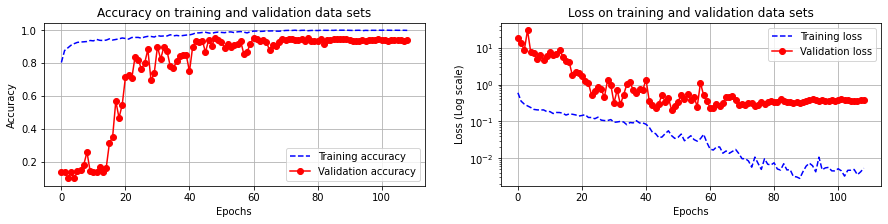

In [71]:
from scripts import plot_history
    
plot_history(history)

## Evaluation du modèle sur train et validation

In [6]:
# on charge le modèle suivant
model = tf.keras.models.load_model(
    '/data/freganet/TPDUIA/tissue_classifier_with_transfer_learning/epochs_120/'
)

In [90]:
loss_train, acc_train = model.evaluate(ds_train, verbose=1)
loss_val, acc_val = model.evaluate(ds_val, verbose=1)

print("\nData set d'apprentissage")
print(f"Loss: {loss_train:.3f}, accuracy: {acc_train:.3f}")
print("\nData set de validation")
print(f"Loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

4/4 [==============================] - 0s 35ms/step - loss: 0.2653 - sparse_categorical_accuracy: 0.9440

Data set d'apprentissage
Loss: 0.917, accuracy: 0.873

Data set de validation
Loss: 0.265, accuracy: 0.944


## Prédictions sur le test

Dans un premier temps, on télécharge le data set de test avec les trois composantes (nom du fichier, image, label) en spécifiant `as_supervised: False`.

In [244]:
# arguments communs
args = {
    'shuffle_files': False, # on permute aléatoirement les images.
    'batch_size': 1, # taille de batch : 1 (pour commencer)
    'as_supervised': False,
    'data_dir': '/data/freganet/TPDU/', #'/content/gdrive/MyDrive/TPDUIA/',
    'with_info': True,
    'download': False
}
ds_test, info = tfds.load(
    'colorectal_histology',
    split='train[90%:]',
    **args
)
# attention, il faut bien reproduire les transformations !
ds_test = ds_test.map(
    lambda x: (preprocessing_pipeline(x['image']), x['label'], x['filename']),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_test = ds_test.map(
    lambda x, label, filename: {
        'image': tf.image.per_image_standardization(x),
        'label': label,
        'filename': filename},
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

filenames_test, images_test, labels_test = store_data(ds_test)

100%|██████████| 500/500 [00:00<00:00, 1764.00it/s]


### Fonction de coût et taux de réussite

In [247]:
loss_test, acc_test = model.evaluate(ds_test.map(lambda x: (x['image'], x['label'])) , verbose=1)
print("\nData set de test")
print(f"Loss: {loss_test:.3f}, accuracy: {acc_test:.3f}")

500/500 [==============================] - 3s 7ms/step - loss: 0.1846 - sparse_categorical_accuracy: 0.9560

Data set de test
Loss: 0.185, accuracy: 0.956


### Probabilités et classes prédites

Syntaxe (voir le script `get_test_predictions_table` dans `scripts.py`):

    predicted_probas_test = model.predict_proba(images_test, verbose=1)
    predicted_classes_test = model.predict_classes(images_test, verbose=1)

In [250]:
from scripts import get_predictions_table

predictions_test = get_test_predictions_table(model, images_test, labels_test, filenames_test)
predictions_test.head(3)

16/16 [==============================] - 0s 12ms/step


probability class 0  probability class 1  probability class 2  \
0         2.938233e-08         9.998838e-01         9.619638e-09   
1         1.000000e+00         9.816988e-16         7.643518e-10   
2         1.997221e-08         9.033504e-20         3.737621e-18   

   probability class 3  probability class 4  probability class 5  \
0         1.488922e-07         1.121189e-04         8.911822e-10   
1         3.921280e-13         3.580946e-08         3.577233e-11   
2         3.015289e-36         2.530072e-18         1.000000e+00   

   probability class 6  probability class 7  predicted class  true class  \
0         3.944281e-06         1.732649e-13                1           1   
1         7.702188e-10         1.493767e-10                0           0   
2         5.596310e-14         7.549734e-20                5           5   

                                            filename  
0    130BB_CRC-Prim-HE-02_015.tif_Row_1051_Col_1.tif  
1    291E_CRC-Prim-HE-09_024.tif_Row_601_Col_151.tif  
2  16859_CRC-Prim-HE-07_001_copy.tif_Row_451_Col_...

On visualise les probabilités avec la classe prédite.

In [251]:
predictions_test.iloc[:, :-1].head(10).style.background_gradient(cmap='Blues')

Où l'algorithme s'est-il trompé ?

In [253]:
erreurs = predictions_test[
    predictions_test['predicted class'] != predictions_test['true class']
]
print(f'{erreurs.shape[0]} erreurs au total\n')
erreurs.iloc[:, :-1].style.background_gradient(cmap='Blues')

22 erreurs au total



### Matrice de confusion

In [255]:
matrix = pd.crosstab(
    predictions_test['predicted class'], predictions_test['true class'],
)
matrix.style.background_gradient(cmap='Blues')

### Taux de réussite par classes

In [285]:
from scripts import get_accuracies
        
get_accuracies(matrix)

Class tumour epithelium: 100.0%
Class simple stroma: 91.4%
Class complex stroma: 91.2%
Class immune cell conglomerate: 95.2%
Class debris and mucus: 91.2%
Class mucosal glands: 98.3%
Class adipose tissue: 100.0%
Class background: 98.3%


# Cartes de segmentation

In [7]:
args = {
    'shuffle_files': False, # on permute aléatoirement les images.
    'batch_size': 1, # taille de batch : 1
    'as_supervised': False, # retourne un couple (image, label)
    'data_dir': '/data/freganet/TPDU/', #'/content/gdrive/MyDrive/TPDUIA/',
    'with_info': True,
    'download': False
}

# on reprend le data set initial.
ds_large, info = tfds.load(
    'colorectal_histology_large',
    split='test',
    **args
)

filenames_large, images_large, _ = store_data(ds_large, add_label=False)
filenames_large = [f.split('_APPLICATION.tif')[0]+'.tif' for f in filenames_large]

100%|██████████| 10/10 [00:02<00:00,  4.58it/s]


In [10]:
# arguments communs
args = {
    'shuffle_files': False, # on permute aléatoirement les images.
    'batch_size': 1, # taille de batch : 1 (pour commencer)
    'as_supervised': False,
    'data_dir': '/data/freganet/TPDU/', #'/content/gdrive/MyDrive/TPDUIA/',
    'with_info': True,
    'download': False
}
ds_all, info = tfds.load(
    'colorectal_histology',
    split='train',
    **args
)
# attention, il faut bien reproduire les transformations !
ds_all = ds_all.map(
    lambda x: (preprocessing_pipeline(x['image']), x['label'], x['filename']),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_all = ds_all.map(
    lambda x, label, filename: {
        'image': tf.image.per_image_standardization(x),
        'label': label,
        'filename': filename},
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

filenames_small, images_small, labels_small = store_data(ds_all)

100%|██████████| 5000/5000 [00:02<00:00, 2203.29it/s]


In [307]:
loss_all, acc_all = model.evaluate(ds_all.map(lambda x: (x['image'], x['label'])) , verbose=1)
print("\nData set entier")
print(f"Loss: {loss_all:.3f}, accuracy: {acc_all:.3f}")

5000/5000 [==============================] - 33s 6ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.9650

Data set entier
Loss: 0.127, accuracy: 0.965


In [390]:
predictions_small = get_predictions_table(model, images_small, labels_small, filenames_small)

157/157 [==============================] - 2s 11ms/step


In [321]:
from pprint import pprint
pprint(filenames_large)

array(['CRC-Prim-HE-04_APPLICATION.tif', 'CRC-Prim-HE-01_APPLICATION.tif',
       'CRC-Prim-HE-09_APPLICATION.tif', 'CRC-Prim-HE-10_APPLICATION.tif',
       'CRC-Prim-HE-06_APPLICATION.tif', 'CRC-Prim-HE-02-APPLICATION.tif',
       'CRC-Prim-HE-03_APPLICATION.tif', 'CRC-Prim-HE-07_APPLICATION.tif',
       'CRC-Prim-HE-05_APPLICATION.tif', 'CRC-Prim-HE-08_APPLICATION.tif'],
      dtype='<U30')


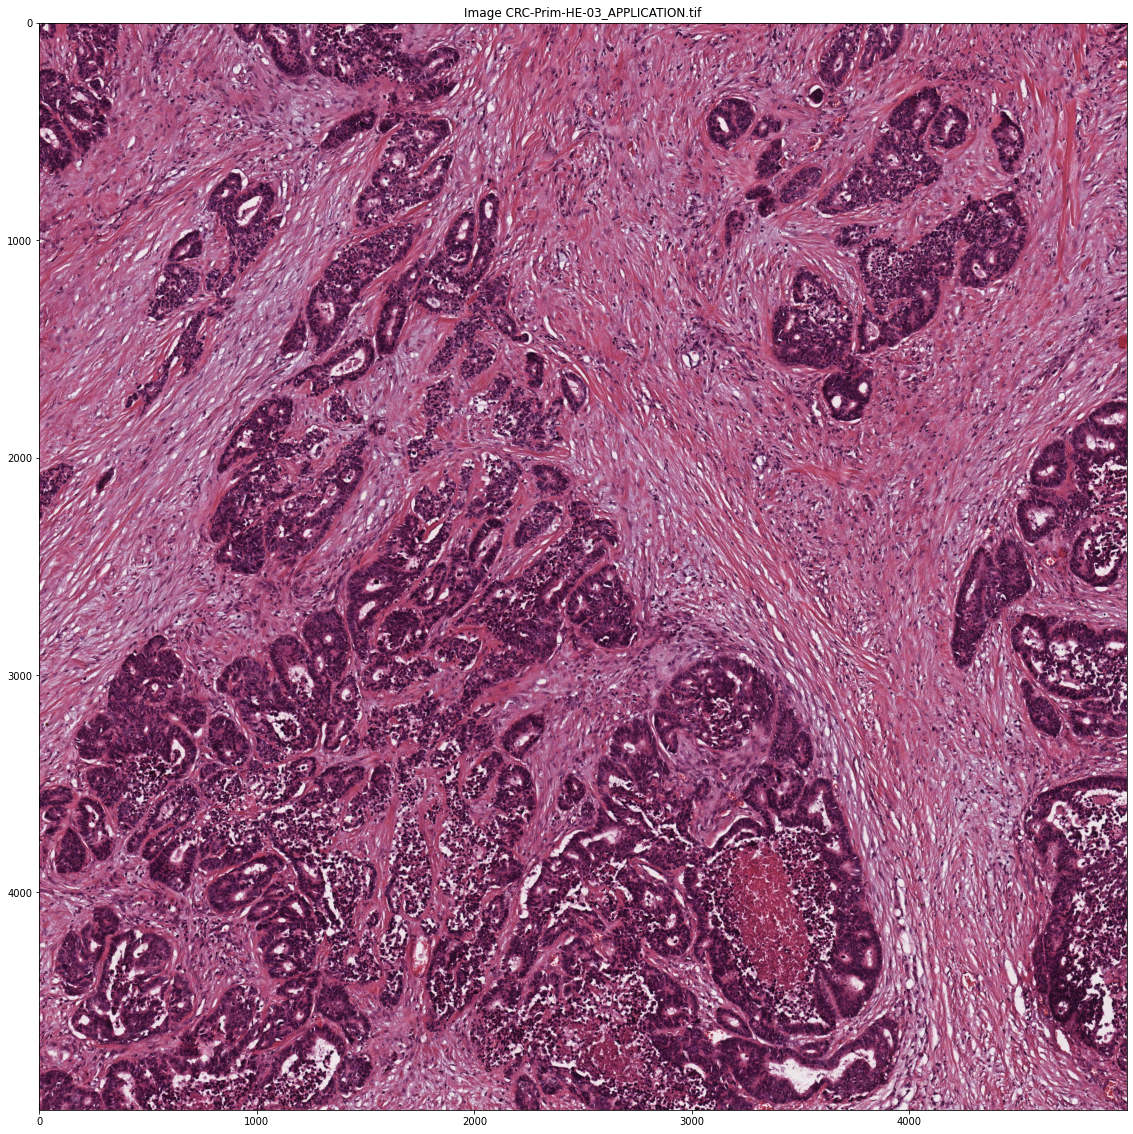

In [319]:
from scripts import plot_large_image

plot_large_image(images_large[6], filenames_large[6])

In [389]:
from importlib import reload
import scripts
reload(scripts)
from scripts import get_predictions_table

In [11]:
image = images_large[0][:4950, :4950]
filename = filenames_large[0]
mask = np.zeros((4950, 4950)) * np.nan

In [12]:

from skimage.util import view_as_blocks

In [14]:
patches = view_as_blocks(
    image,
    block_shape=(150, 150, 3)
)[:, :, 0, :, :, :]
patches = patches.reshape(33*33, 150, 150, 3) * (1./255)
patches = tf.image.per_image_standardization(patches)

In [15]:
predictions = model.predict_classes(patches, verbose=1).reshape((33, 33))

35/35 [==============================] - 5s 18ms/step


In [16]:
for i in range(33):
    for j in range(33):
        mask[(i*150):((i+1)*150), (j*150):((j+1)*150)] = predictions[i, j]

In [17]:
from scipy.ndimage import gaussian_filter
import matplotlib
from PIL import Image
from skimage.transform import resize

In [18]:
mask_r = resize(mask, (1000, 1000))
image_r = np.array(
    Image.fromarray(image).resize((1000, 1000))
)

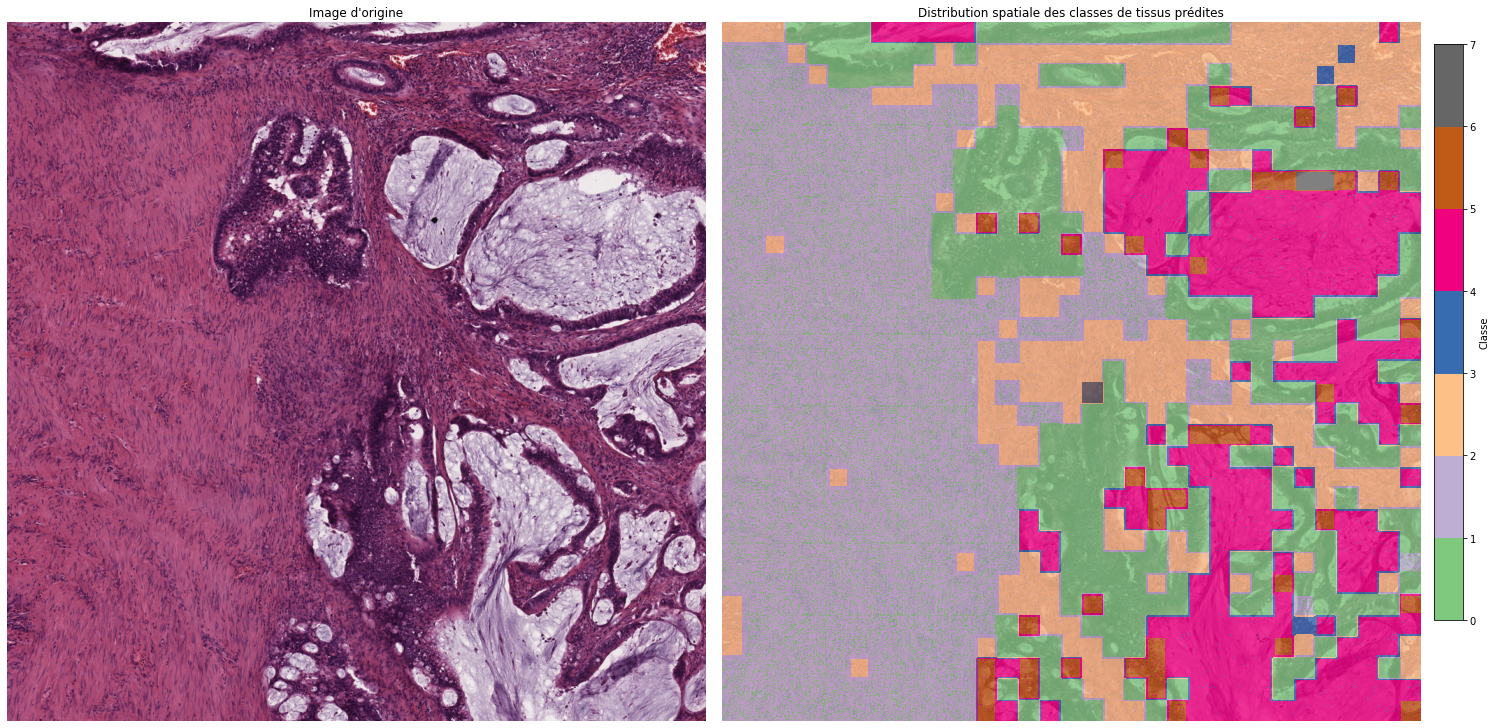

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
blur_mask = gaussian_filter(mask_r, sigma=0, order=0)
# affichage du masque de probabilités
ax = axes[0]
ax.imshow(image_r);ax.axis('off')
ax.set_title("Image d'origine")
ax = axes[1]
ax.imshow(image_r);ax.axis('off')
cmap = matplotlib.cm.get_cmap('Accent', 7)
ax.imshow(blur_mask, cmap=cmap, alpha=0.8)
ax.set_title(f'Distribution spatiale des classes de tissus prédites')
norm = matplotlib.colors.Normalize(vmin=0, vmax=7)
cbar_ax = fig.add_axes([1.00, 0.155, 0.02, 0.8])
fig.colorbar(
    matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    cax=cbar_ax,
    label='Classe',
    aspect=20
)

plt.tight_layout()
plt.show()